# 🌀 RealNVP

In this notebook, we'll walk through the steps required to train your own RealNVP network to predict the distribution of a demo dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the PixelCNN](#build)
3. [Train the PixelCNN](#train)
4. [Generate images](#generate)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.datasets import make_moons

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 0. Parameters <a name="parameters"></a>

In [23]:
BATCH_SIZE = 256
EPOCHS = 300

In [24]:
# Load the data
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = keras.layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

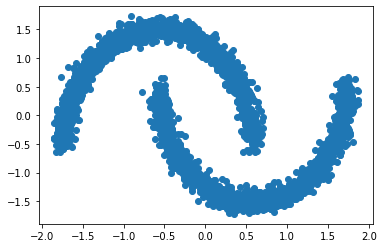

In [25]:
plt.scatter(normalized_data.numpy()[:,0], normalized_data.numpy()[:,1])
plt.show()


## 2. Build the RealNVP network <a name="build"></a>

In [15]:
output_dim = 256
reg = 0.01

def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [16]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
model = RealNVP(num_coupling_layers=6)

## 3. Train the RealNVP network <a name="train"></a>

In [17]:
# Compile and train the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

In [18]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples
  
    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples)
        
        return x, z, samples

        
    def display(self, x, z, samples, save_to = None):
        plt.figure(figsize=(15, 10))
        
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(20, 15)

        axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
        axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
        axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
        axes[0, 1].set_xlim([-3.5, 4])
        axes[0, 1].set_ylim([-4, 4])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
        axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
        axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])
        
        if save_to:
            out = plt.savefig(save_to)
            print(f'\nSaved to {save_to}')

    def on_epoch_end(self, epoch, logs=None):
        x, z, samples = self.generate()
        self.display(x, z, samples, save_to = "./output/generated_img_%03d.png" % (epoch))
        
img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
94/94 [==============================] - 2s 9ms/step

Saved to ./output/generated_img_000.png
3/3 [==============================] - 9s 2s/step - loss: 2.8254 - val_loss: 2.7772
Epoch 2/300
94/94 [==============================] - 1s 7ms/step

Saved to ./output/generated_img_001.png
3/3 [==============================] - 2s 1s/step - loss: 2.7428 - val_loss: 2.7764
Epoch 3/300
94/94 [==============================] - 1s 10ms/step

Saved to ./output/generated_img_002.png
3/3 [==============================] - 2s 1s/step - loss: 2.7131 - val_loss: 2.8661
Epoch 4/300
94/94 [==============================] - 1s 10ms/step

Saved to ./output/generated_img_003.png
3/3 [==============================] - 2s 996ms/step - loss: 2.7006 - val_loss: 2.9403
Epoch 5/300
94/94 [==============================] - 1s 12ms/step

Saved to ./output/generated_img_004.png
3/3 [==============================] - 2s 1s/step - loss: 2.6862 - val_loss: 2.9379
Epoch 6/300
94/94 [=========================

/tmp/ipykernel_14/4251931037.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 10))



Saved to ./output/generated_img_010.png
3/3 [==============================] - 2s 984ms/step - loss: 2.6529 - val_loss: 2.9117
Epoch 12/300
94/94 [==============================] - 1s 9ms/step

Saved to ./output/generated_img_011.png
3/3 [==============================] - 2s 933ms/step - loss: 2.6470 - val_loss: 2.9249
Epoch 13/300
94/94 [==============================] - 1s 14ms/step

Saved to ./output/generated_img_012.png
3/3 [==============================] - 4s 2s/step - loss: 2.6339 - val_loss: 2.9177
Epoch 14/300


KeyboardInterrupt: 

<Figure size 1080x720 with 0 Axes>

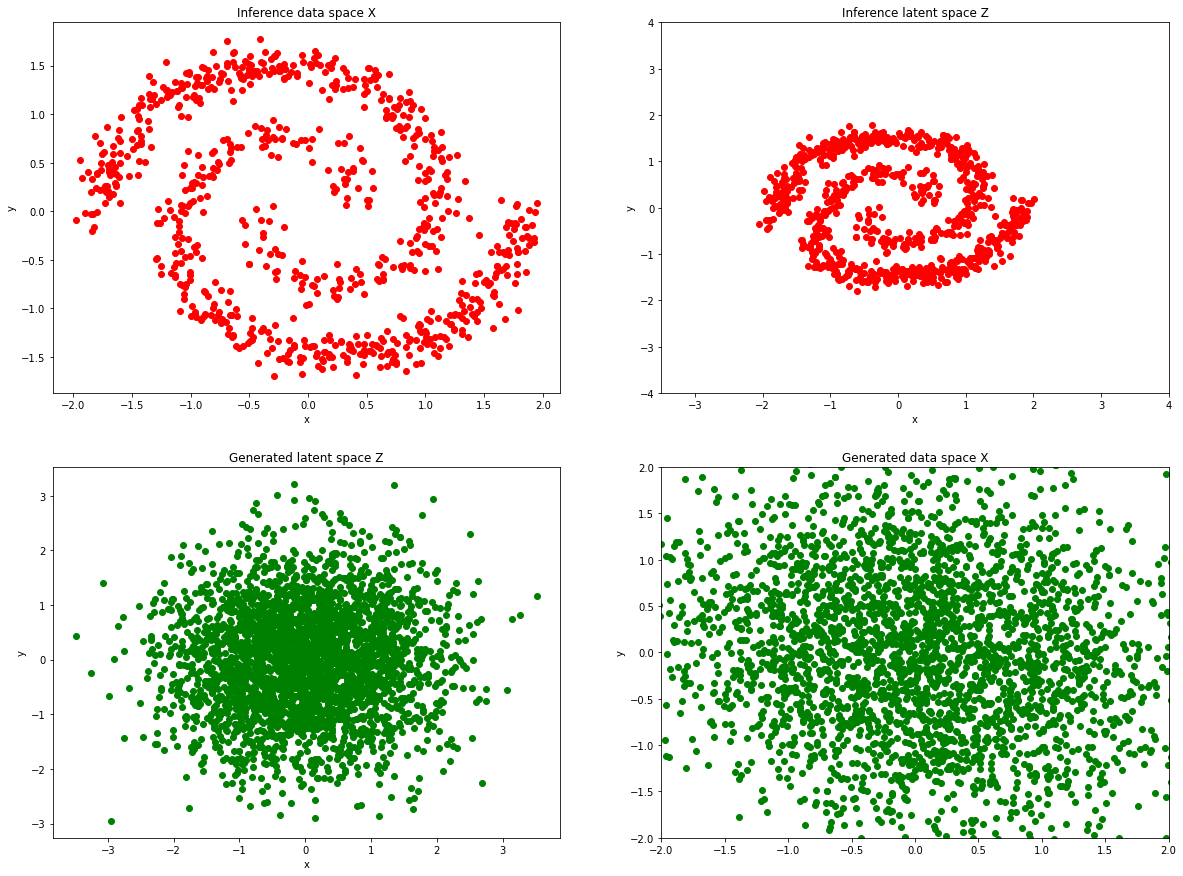

<Figure size 1080x720 with 0 Axes>

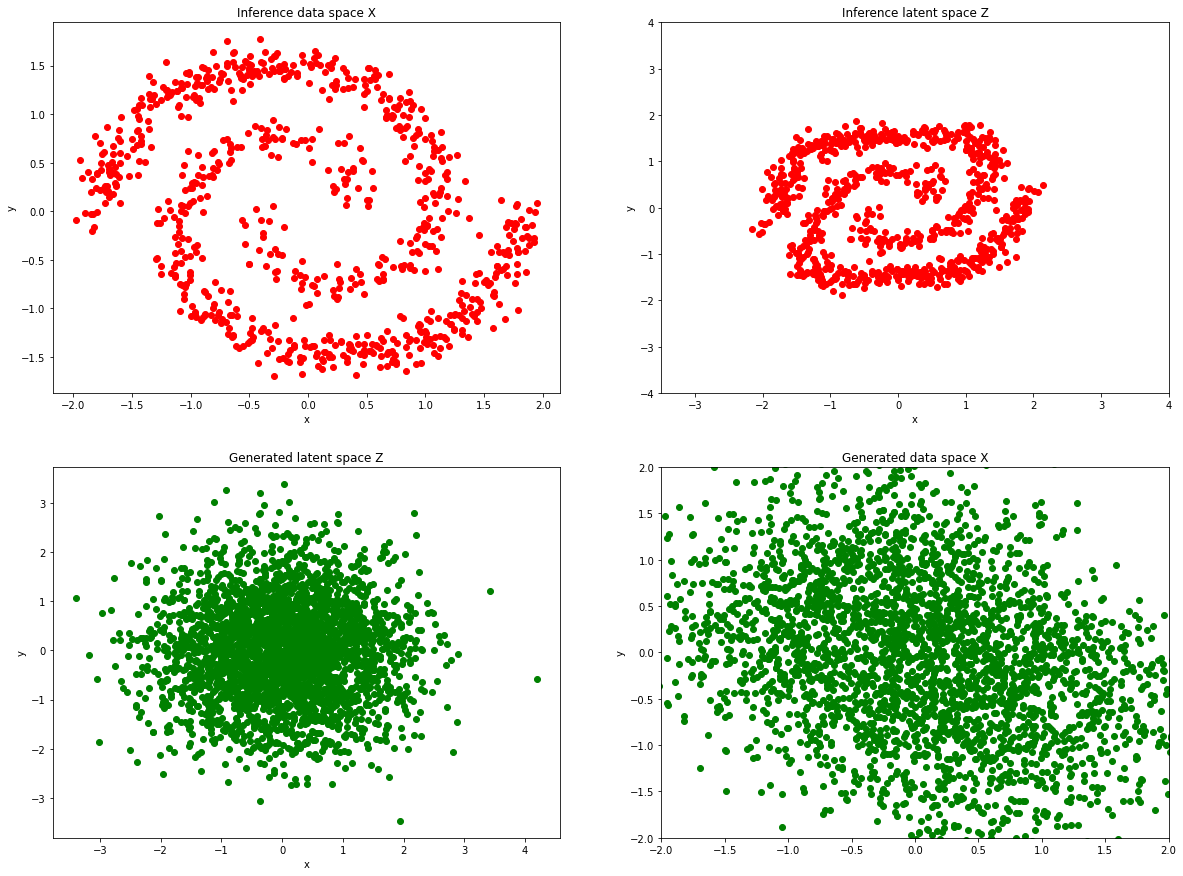

<Figure size 1080x720 with 0 Axes>

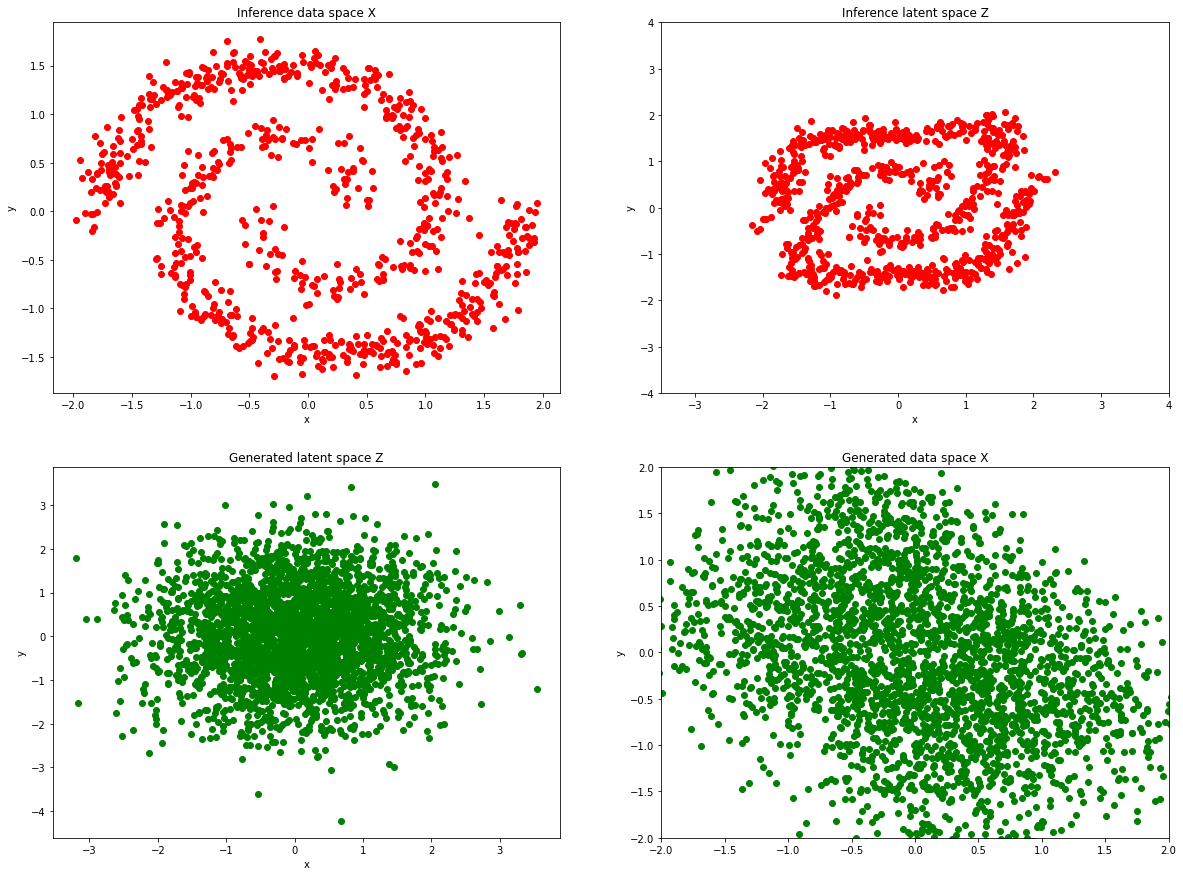

<Figure size 1080x720 with 0 Axes>

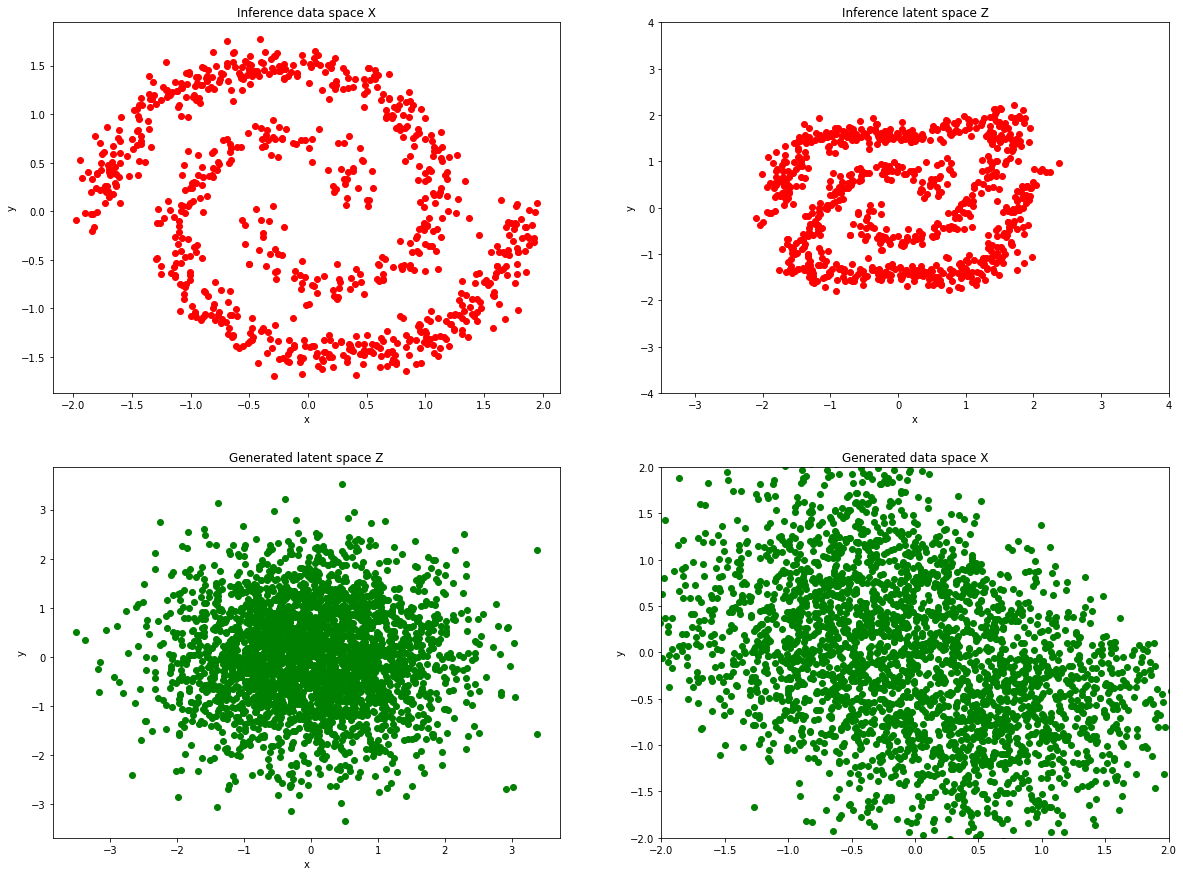

<Figure size 1080x720 with 0 Axes>

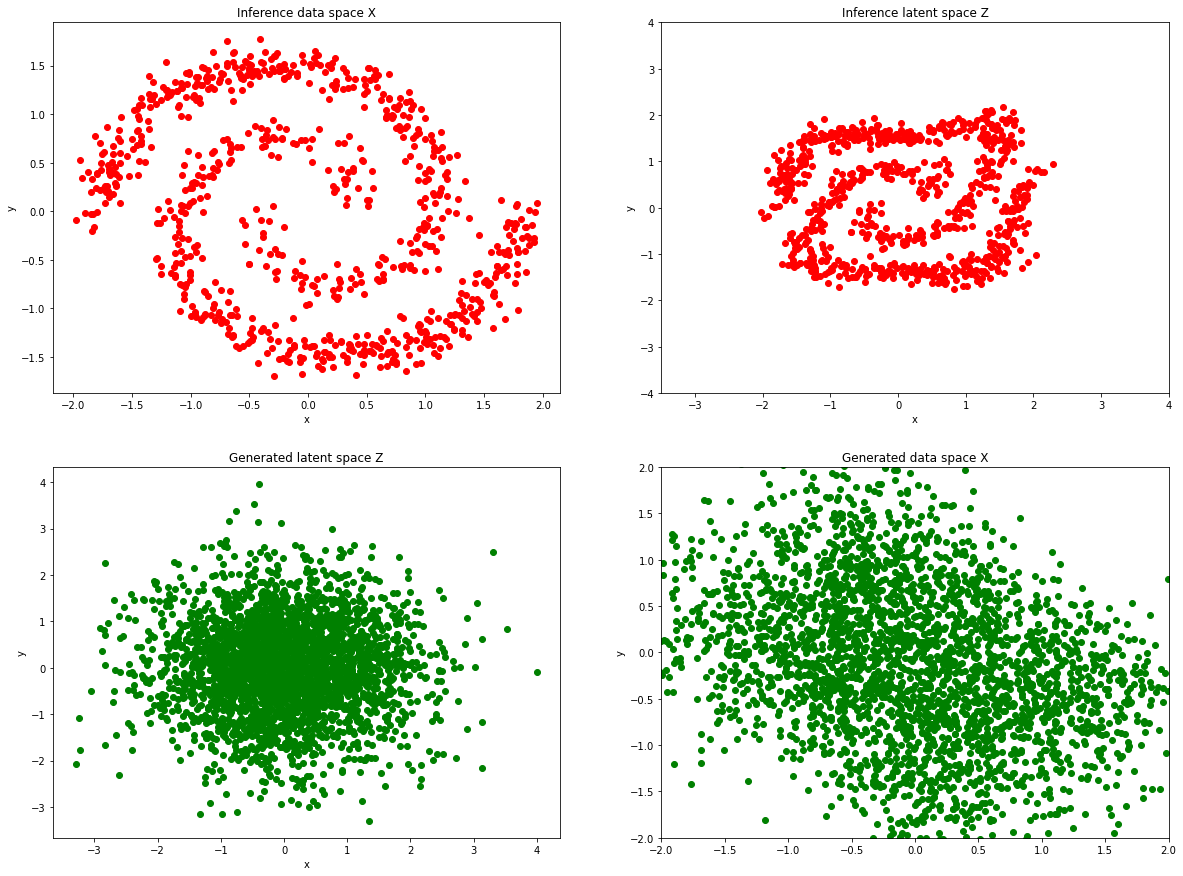

<Figure size 1080x720 with 0 Axes>

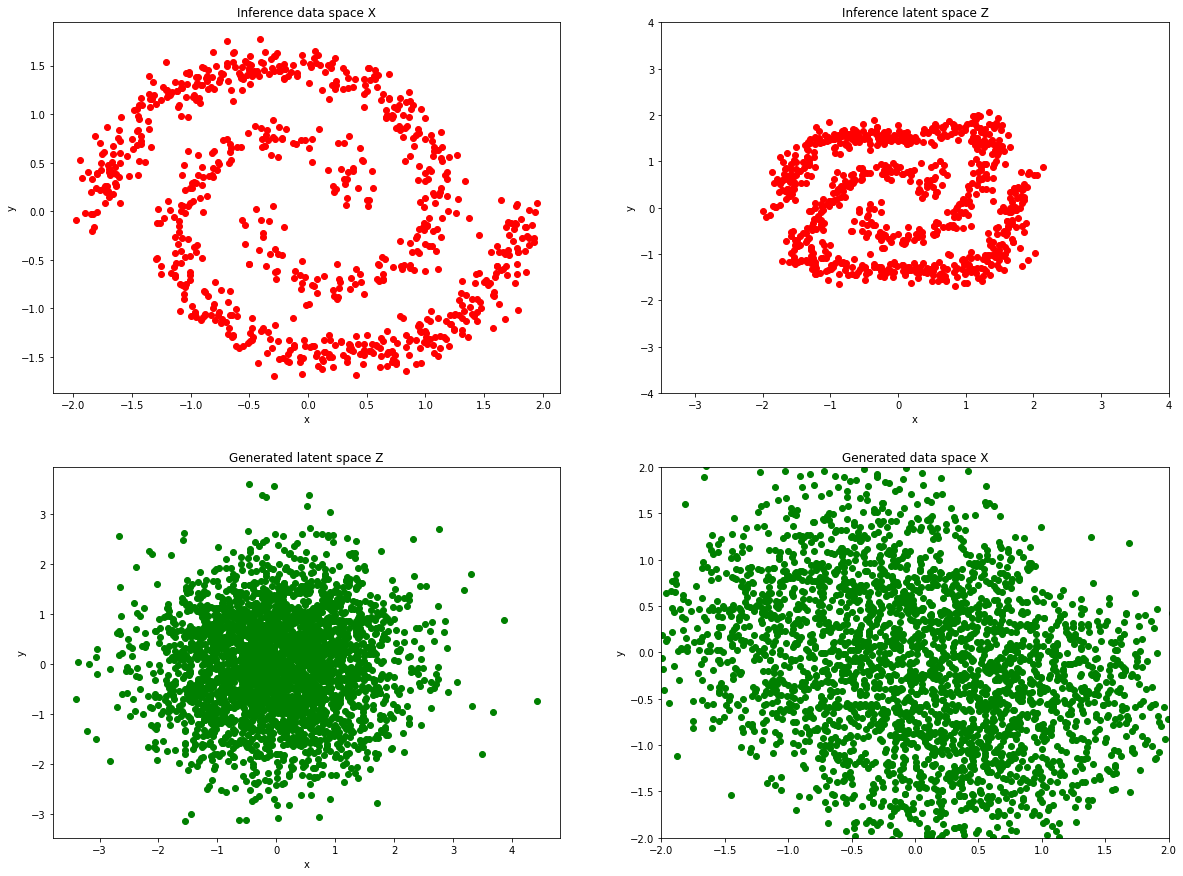

<Figure size 1080x720 with 0 Axes>

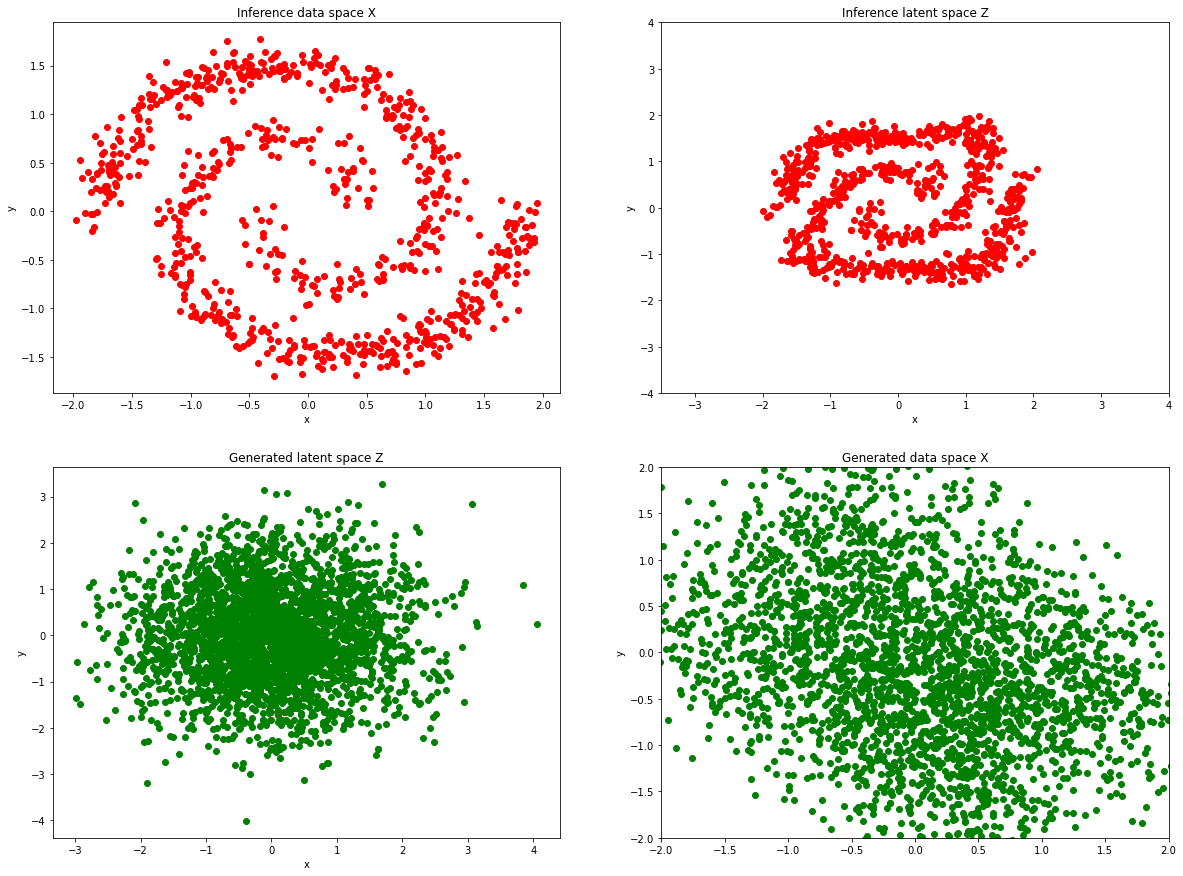

<Figure size 1080x720 with 0 Axes>

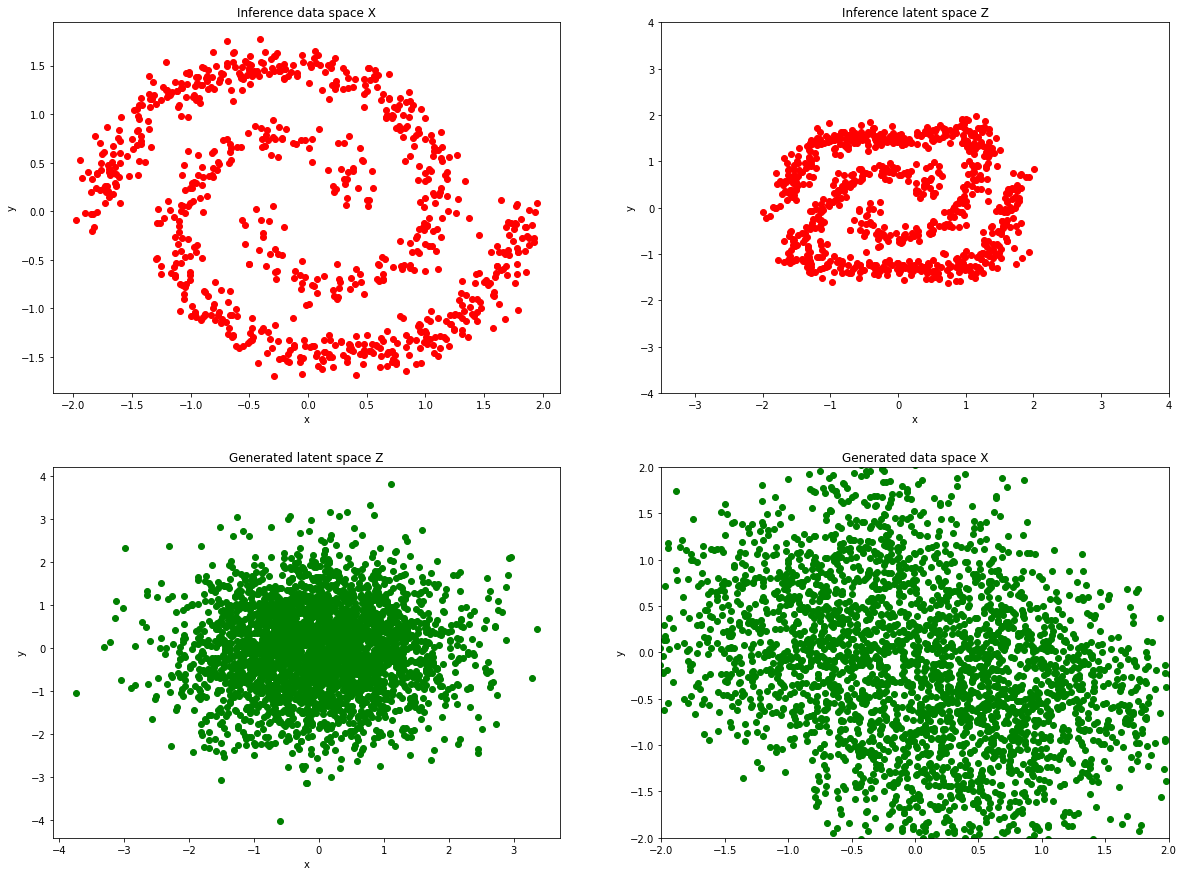

<Figure size 1080x720 with 0 Axes>

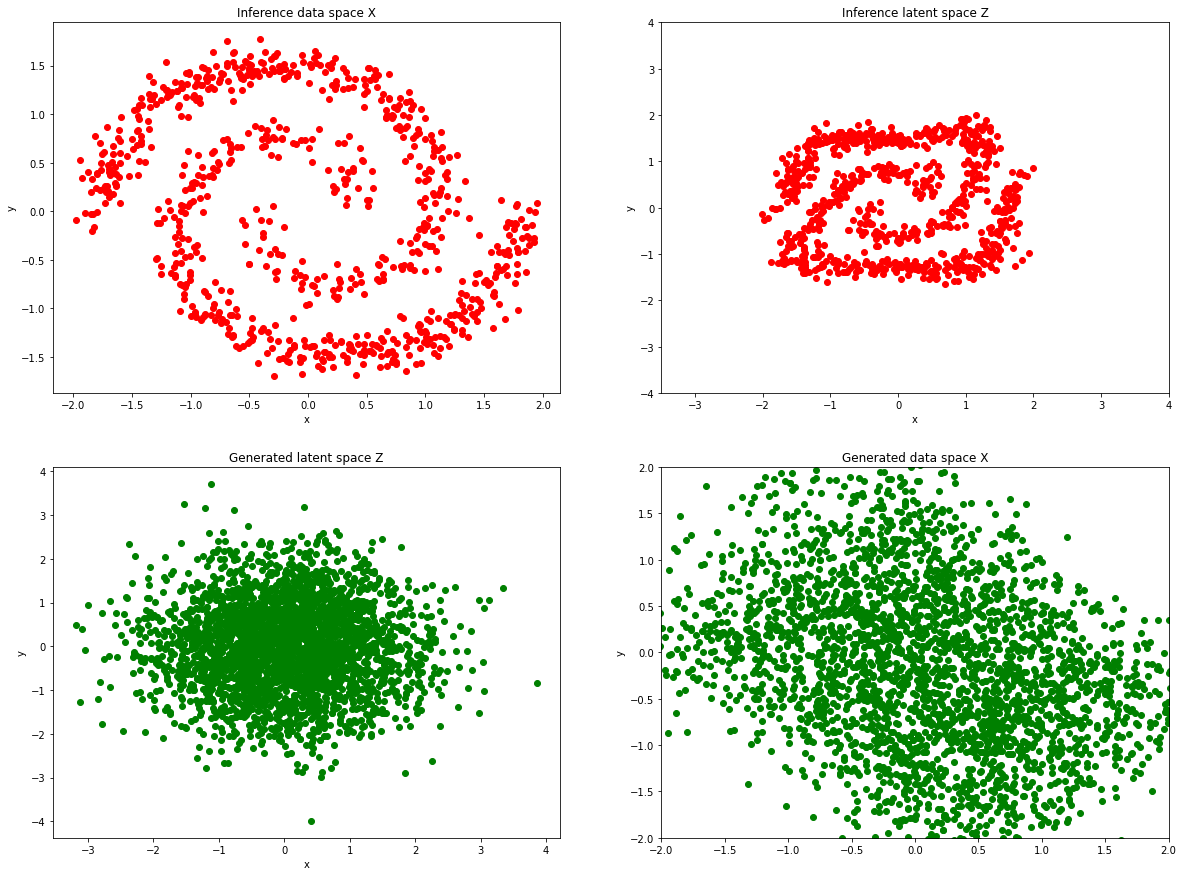

<Figure size 1080x720 with 0 Axes>

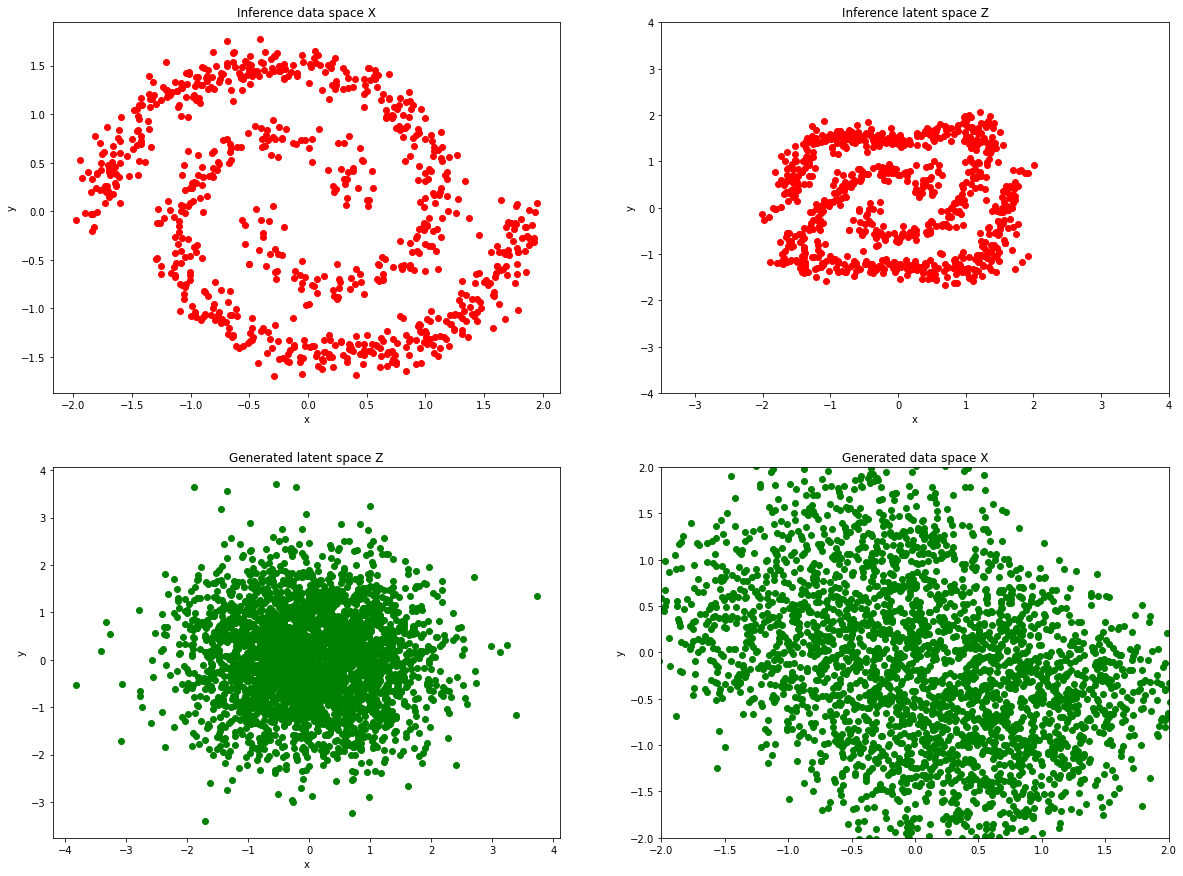

<Figure size 1080x720 with 0 Axes>

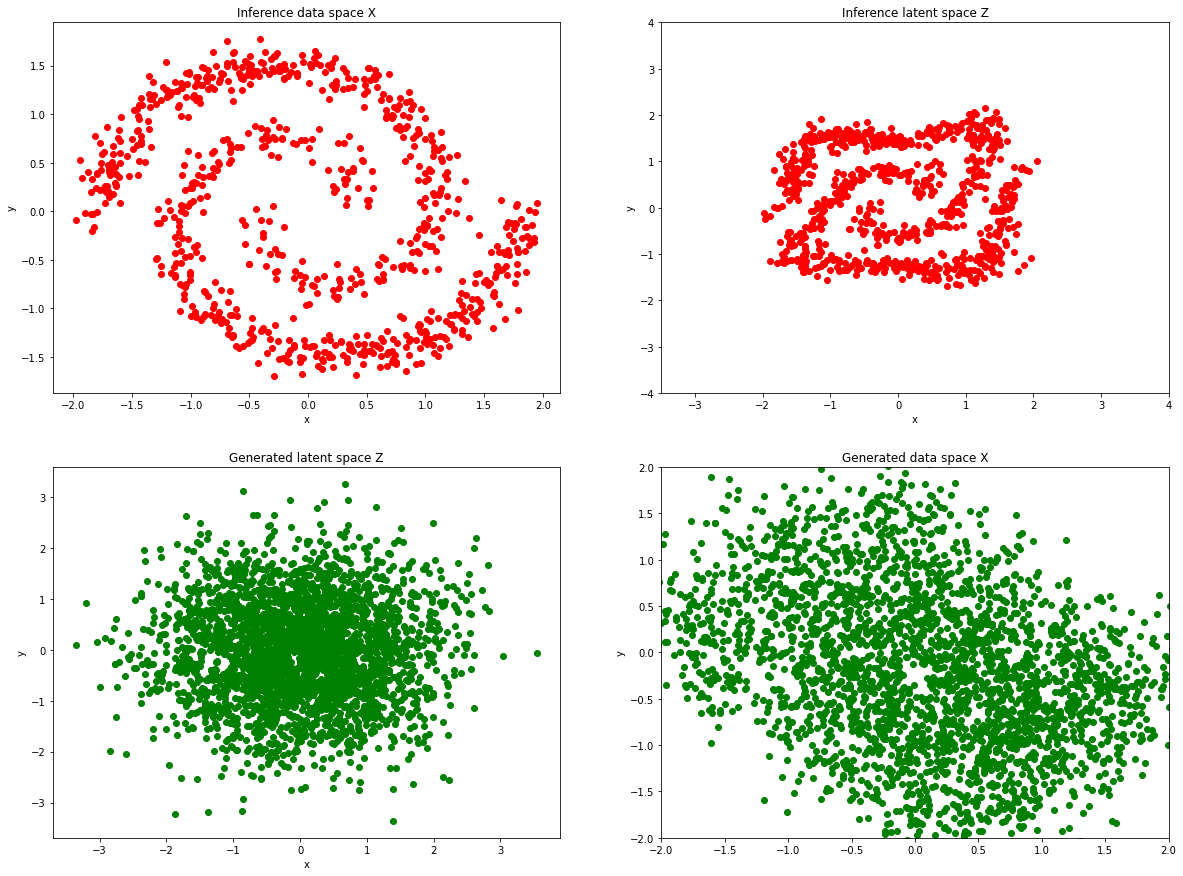

<Figure size 1080x720 with 0 Axes>

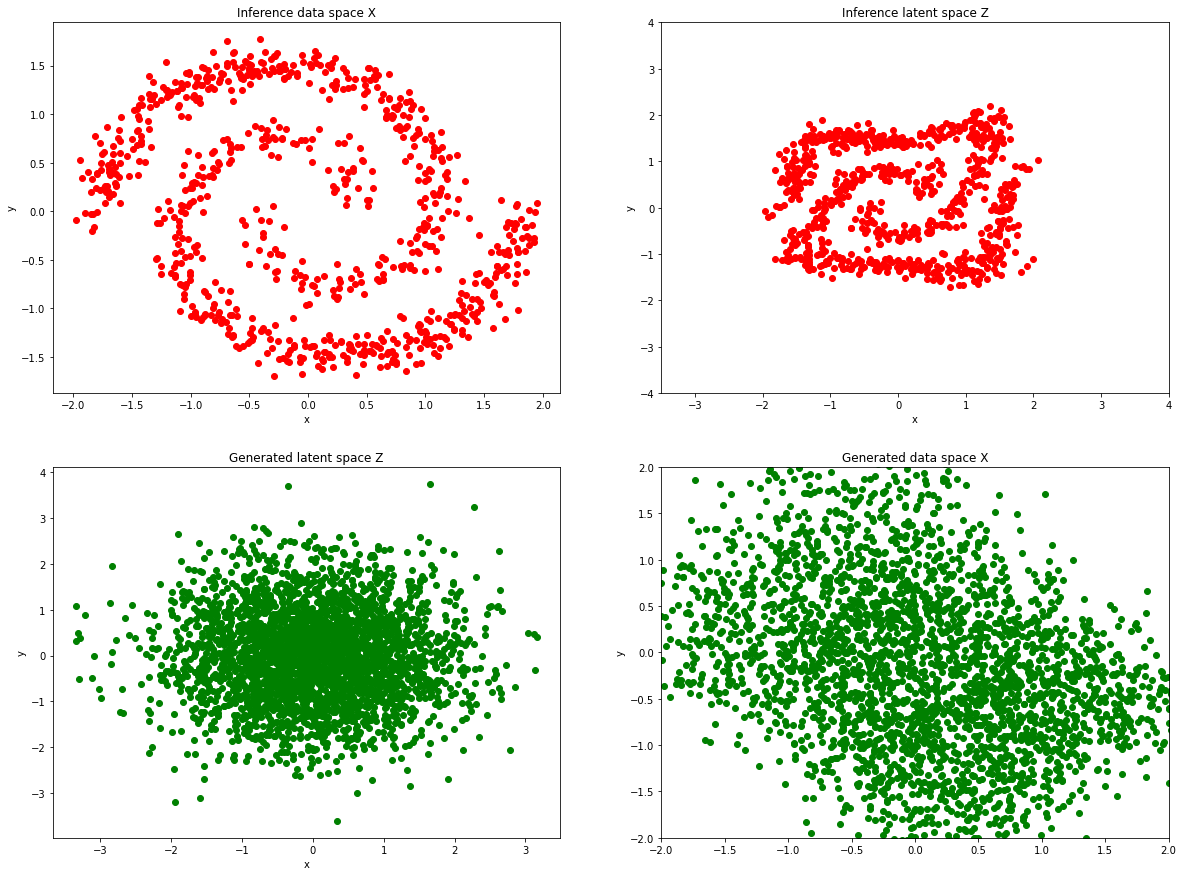

<Figure size 1080x720 with 0 Axes>

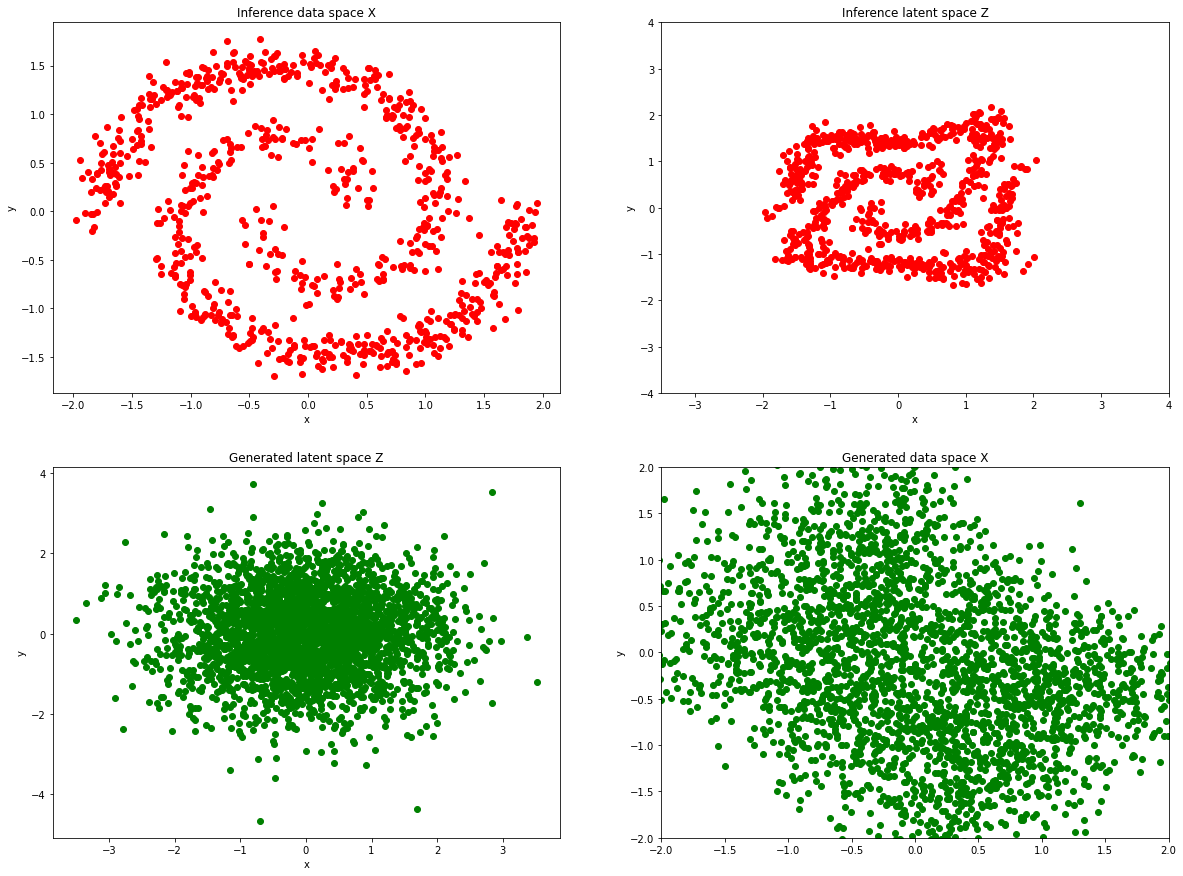

In [19]:
model.fit(
    normalized_data
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , validation_split=0.2
    , callbacks = [tensorboard_callback, img_generator_callback]
)

## 4. Generate images <a name="generate"></a>

In [56]:
x, z, samples = img_generator_callback.generate()

94/94 [==============================] - 1s 16ms/step


<Figure size 1080x720 with 0 Axes>

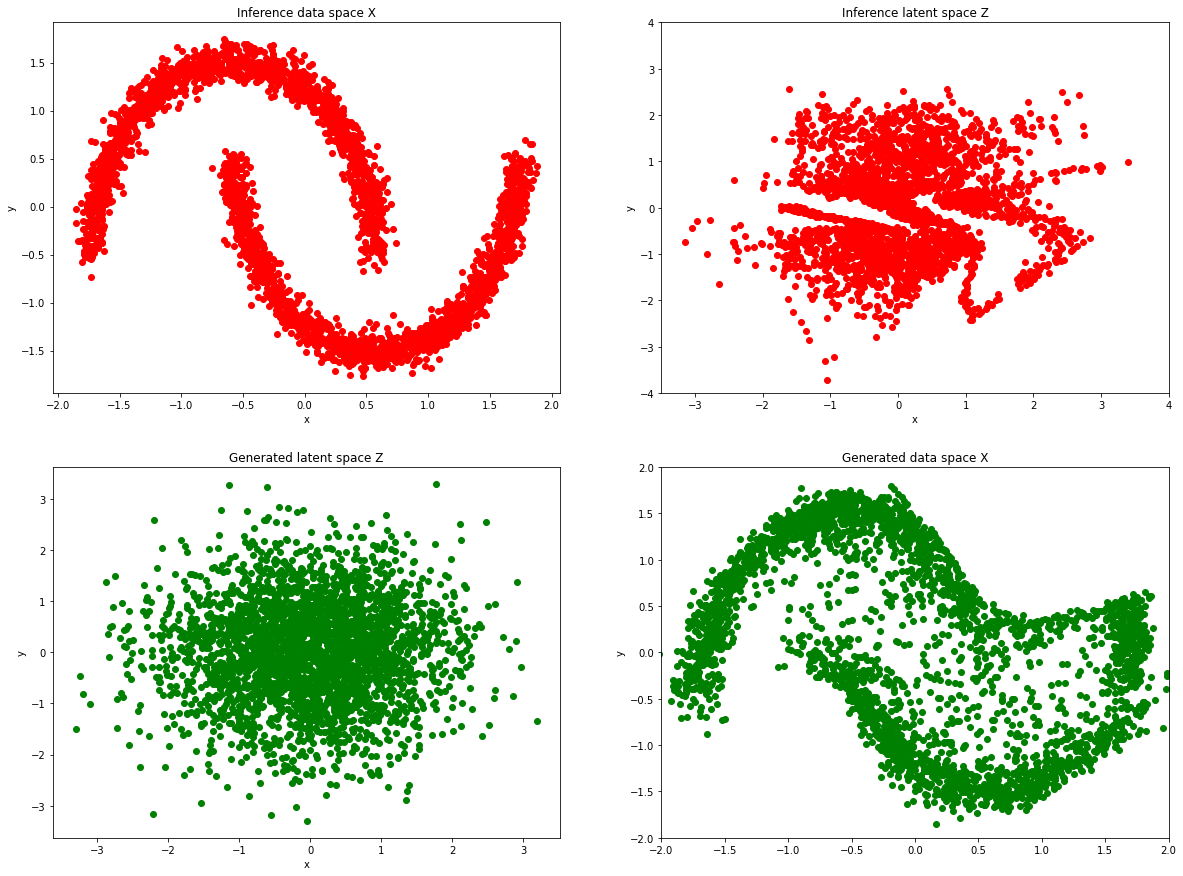

In [57]:
img_generator_callback.display(x, z, samples)